# Discover governing equations in spring-mass-damping systems

- **Authors**: Xiaoyu Xie, Zhengtao Gan
- **Contact**: xiaoyuxie2020@u.northwestern.edu
- **Date**: Nov. 2021

**Important files:**

- main file: this jupyter notebook: `./tutorials/discover_pde.ipynb`
- configuration: `./configs/config_oscillation.yml`, which stores some training hyper-paramters, dataset path, etc.
- dimension matrix and basis coefficients are stored in: `./utils/dimension_zoo.py`
- results will be saved in: `./results`
- you can generate more and different dataset using: `./utils/gen_pde_dataset.py`, but be sure to save the dataset in `./dataset` and change the `dataset_file` in `./configs/config_oscillation.yml`.
- calculate BIC: `./utils/BIC.py`

In [1]:
import copy

import json
import os
import sys

from derivative import dxdt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

root_path = os.path.dirname(os.path.abspath(''))
sys.path.append(root_path)

from utils.BIC import calculate_BIC
from utils.tools import NumpyEncoder
from utils.dimension_zoo import DimensionZoo
from utils import config_parser

%matplotlib inline
    
# read config file
config_name = 'configs/config_oscillation.yml'
config_path = os.path.join(root_path, config_name)
config = config_parser.ConfigParser(config_path)

# create a folder called "results" to save results
results_dir = os.path.join(root_path, 'results')
if not os.path.exists(results_dir):
    os.mkdir(results_dir)

# this variable stores the dimension matrix information
dimension_zoo = DimensionZoo()

In [2]:
# read config file
config_name = 'configs/config_oscillation.yml'
config_path = os.path.join(root_path, config_name)
config = config_parser.ConfigParser(config_path)

dimension_zoo = DimensionZoo()

plt.rcParams["font.family"] = "Arial"

In [3]:
# show configs
for attr in dir(config):
    if '__' not in attr:
        print(f'[CONFIG] {attr}: ', eval(f'config.{attr}'))

[CONFIG] base_vec_num:  0
[CONFIG] batch_size:  1
[CONFIG] dataset_file:  ./dataset/dataset_oscillation.csv
[CONFIG] degree:  2
[CONFIG] dimless_num:  1
[CONFIG] display_num:  5
[CONFIG] dnn_mat_file:  None
[CONFIG] dnn_mat_num:  1
[CONFIG] epoch_num:  100
[CONFIG] fix_dnn_mat:  True
[CONFIG] fix_scaling_mat:  True
[CONFIG] hidden_num:  10
[CONFIG] input_labels:  ['A0', 't', 'm', 'k', 'c']
[CONFIG] is_loglize_input:  True
[CONFIG] is_loglize_output:  False
[CONFIG] is_normlize_output:  False
[CONFIG] lr_initial:  0.01
[CONFIG] metric_list:  ['mean_absolute_error', 'mean_relative_error', 'mean_squared_error', 'r2_score']
[CONFIG] model_name:  DimensionNet
[CONFIG] output_index:  0
[CONFIG] output_labels:  ['x']
[CONFIG] pretrained_path:  random
[CONFIG] problem_type:  oscillation
[CONFIG] random_split_num:  1
[CONFIG] reverse_input:  True
[CONFIG] reverse_output:  True
[CONFIG] split_seed:  1
[CONFIG] tag:  x


In [4]:
def load_dataset(dataset_path, problem_type):
    '''Load spring-mass-damping dataset'''
    df = pd.read_csv(dataset_path)
    X = np.array(df[config.input_labels])
    y = np.array(df[config.output_labels])
    return X, y

def gen_equ(coef, X_library_names, y_library_name, threshold):
    '''generate equation in string'''
    equ = y_library_name
    non_zero_term = 0
    for idx, i in enumerate((coef).tolist()):
        if i != 0.0 and i < 20 and abs(i)>threshold:
            equ += f'+{-1*round(i, 2)}*{X_library_names[idx]}'
            non_zero_term += 1
    equ += '=0'
    return equ, non_zero_term

[DATASET] shape:  (3000, 5) (3000, 1)
dnn_mat [[ 1.]
 [-1.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]


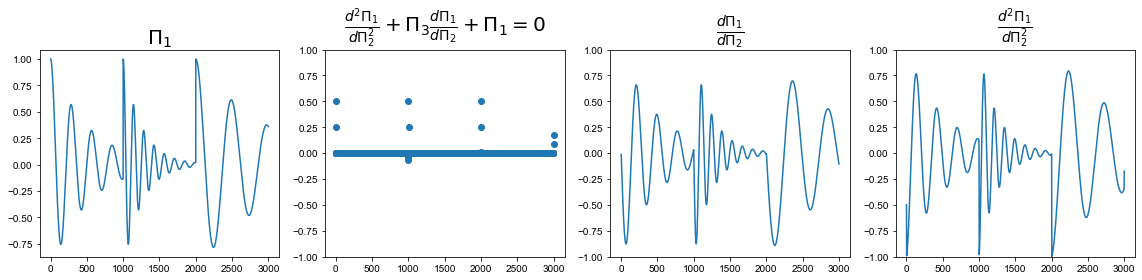

Equation: pi1''+0.99*pi1+0.99*pi3*pi1'=0
[INFO] a: 0-0.5, b: 0--0.5, c: 0--0.5, d: 0--0.5, r2_train: 0.9976
     a    b    c    d  r2_train  mse_train           BIC  \
0  0.5 -0.5 -0.5 -0.5  0.997592   0.000321 -24068.809451   

                         equation  
0  pi1''+0.99*pi1+0.99*pi3*pi1'=0  


In [5]:
# load dataset
dataset_file = os.path.join(root_path, config.dataset_file)
X_train, y_train = load_dataset(dataset_file, config.problem_type)
print('[DATASET] shape: ', X_train.shape, y_train.shape)

# variable definition
# 1. scaling_mat: basis vectors in different columns
# 2. input_dim_mat: input dimension matrix
# 3. output_dim_mat: output dimension matrix
# 4. dnn_mat: w for output dimensionless number
input_dim_mat, output_dim_mat, scaling_mat, dnn_mat = dimension_zoo.fetch_dim(
    config.problem_type)

# define the number of basis vectors
# this spring-mass-damping example is 2
config.base_vec_num = scaling_mat.shape[1]

# output: w for output dimensionless number
# note that in this example we fix a dimensionless length x/\delta
dnn_mat = np.array([1., -1., 0., 0., 0., 0.]).reshape(-1, 1)

pi1_str = r'$\Pi_1$'
pi2_str = r'$\Pi_2$'

res = []
print('dnn_mat', dnn_mat)

# initialize basis coefficients
basis1_in, basis2_in = scaling_mat[:, 0], scaling_mat[:, 1]
st_point, end_point, n_points = -1, 1, 20  # range: [-1, 1]
a_arr = np.linspace(st_point, end_point, n_points+1, endpoint=True)
b_arr = np.linspace(st_point, end_point, n_points+1, endpoint=True)
c_arr = np.linspace(st_point, end_point, n_points+1, endpoint=True)
d_arr = np.linspace(st_point, end_point, n_points+1, endpoint=True)

is_visualize = True

# note that you should uncomment these four lines if you want to do grid search
#         for idx_a, a in enumerate([0.5]):
#             for idx_b, b in tqdm(enumerate(b_arr)):
#                 for idx_c, c in enumerate(c_arr):
#                     for idx_d, d in enumerate(d_arr):

# these four lines are best basis coefficients
for idx_a, a in enumerate([0.5]):
    for idx_b, b in enumerate([-0.5]):
        for idx_c, c in enumerate([-0.5]):
            for idx_d, d in enumerate([-0.5]):
                coef_pi2 = np.dot(scaling_mat, np.array([a, b]).reshape(-1, 1)).reshape(-1,)
                coef_pi3 = np.dot(scaling_mat, np.array([c, d]).reshape(-1, 1)).reshape(-1,)

                input_all_train = np.hstack([y_train.reshape(-1, 1), X_train])

                # reverse input to original space
                pi3_train = np.prod(np.power(X_train, coef_pi3), axis=1)  # c'=c/sqrt(mk)
                pi2_train = np.prod(np.power(X_train, coef_pi2), axis=1)  # t'=t/sqrt(m/k)
                pi1_train = np.prod(np.power(input_all_train, dnn_mat.reshape(-1,)), axis=1) # x'=x/A0

                # note to remember the meaning for pi1, pi2, and pi3
                # pi1: x'=x/A0, pi2: t'=t/sqrt(m/k), pi3: c'=c/sqrt(mk)
                try:
                    # the length for each set of data
                    N_point = 1000
                    # first-order and second-order derivatives
                    dpi1_dpi2_all, dpi12_dpi22_all = [], []
                    for i in range(3):  # we only used 3 sets of data
                        dpi1_dpi2_part1 = dxdt(
                            pi1_train[N_point*i:N_point*(i+1)], pi2_train[N_point*i:N_point*(i+1)], kind='finite_difference', k=1)
                        dpi12_dpi22_part1 = dxdt(
                            dpi1_dpi2_part1, pi2_train[N_point*i:N_point*(i+1)], kind='finite_difference', k=1)
                        dpi1_dpi2_all.append(dpi1_dpi2_part1)
                        dpi12_dpi22_all.append(dpi12_dpi22_part1)
                    dpi1_dpi2 = np.hstack(dpi1_dpi2_all)
                    dpi12_dpi22 = np.hstack(dpi12_dpi22_all)

                    # visulization for derivatives
                    if is_visualize:
                        fig = plt.figure(figsize=(16, 4))
                        fig.add_subplot(1, 4, 1)
                        plt.plot(pi1_train)
                        plt.title(r'$\Pi_1$', fontsize=20)
                        fig.add_subplot(1, 4, 2)
                        plt.scatter(range(pi1_train.shape[0]), dpi12_dpi22+pi3_train * dpi1_dpi2+pi1_train)
                        plt.ylim([-1, 1])
                        plt.title(r"$\frac{d^2\Pi_1}{d\Pi_2^2} + \Pi_3 \frac{d\Pi_1}{d\Pi_2} + \Pi_1=0$", fontsize=20)
                        fig.add_subplot(1, 4, 3)
                        plt.plot(dpi1_dpi2)
                        plt.ylim([-1, 1])
                        plt.title(r"$\frac{d\Pi_1}{d\Pi_2}$", fontsize=20)
                        fig.add_subplot(1, 4, 4)
                        plt.plot(dpi12_dpi22)
                        plt.ylim([-1, 1])
                        plt.title(r"$\frac{d^2\Pi_1}{d\Pi_2^2}$", fontsize=20)
                        plt.tight_layout()
                        plt.show()
                    
                    # construct a library for sparse regression
                    X_library = np.stack(
                        (
                            pi1_train, 
                            pi2_train, 
                            pi3_train, 
                            dpi1_dpi2,
                            pi1_train * dpi1_dpi2,
                            pi2_train * dpi1_dpi2,
                            pi3_train * dpi1_dpi2,
                        ), axis=-1)
                    y_library = dpi12_dpi22
                    X_library_names = [
                        "pi1", "pi2", "pi3", "pi1'", "pi1*pi1'", "pi2*pi1'", "pi3*pi1'"]
                    y_library_name = "pi1''"

                    # fit
                    threshold = 0.3
                    model = LinearRegression(fit_intercept=True)
                    model.fit(X_library, y_library)
                    r2_train = model.score(X_library, y_library)
                    # mse_train = mean_squared_error(X_library, y_library)

                    # find sparse coefficients
                    for i in range(3):
                        coef = model.coef_
                        flag = np.repeat((np.abs(coef) > threshold).astype(int).reshape(1,-1), X_library.shape[0], axis=0)
                        X1 = copy.copy(X_library)
                        X1 = np.multiply(X1, flag)
                        model.fit(X1, y_library)
                        r2_train = model.score(X1, y_library)
                        preds = model.predict(X1)
                        mse_train = mean_squared_error(y_library, preds)

                    # claculate BIC
                    equ, non_zero_term = gen_equ(coef, X_library_names, y_library_name, threshold)
                    BIC = calculate_BIC(preds, y_library, non_zero_term)
                    # print('BIC', BIC)
                    print(f'Equation: {equ}')
                except:
                    print('Fit error')
                    r2_train, mse_train, equ = 0, -1, ''

                info = {
                    'a': a, 'b': b, 'c': c, 'd': d,
                    'r2_train': r2_train, 'mse_train': mse_train,
                    'BIC': BIC, 'equation': equ}
                res.append(info)
                print(
                    f'[INFO] a: {idx_a}-{a}, b: {idx_b}-{b}, c: {idx_c}-{c}, d: {idx_d}-{d}, r2_train: {round(r2_train,4)}')

    df = pd.DataFrame(res)
    print(df.head())
    output_file = os.path.join(root_path, 'results/pde.csv')
    df.to_csv(output_file)

# Reference

- [1] **Xie, X.**, Liu, W. K., & **Gan, Z.** (2021). Data-driven discovery of dimensionless numbers and scaling laws from experimental measurements. ArXiv:2111.03583 [Physics]. http://arxiv.org/abs/2111.03583
- [2] **Gan, Z.**, Kafka, O. L., Parab, N., Zhao, C., Fang, L., Heinonen, O., Sun, T., & Liu, W. K. (2021). Universal scaling laws of keyhole stability and porosity in 3D printing of metals. Nature Communications, 12(1), 2379. https://doi.org/10.1038/s41467-021-22704-0
- [3] Saha, S., **Gan, Z.**, Cheng, L., Gao, J., Kafka, O. L., **Xie, X.**, Li, H., Tajdari, M., Kim, H. A., & Liu, W. K. (2021). Hierarchical Deep Learning Neural Network (HiDeNN): An artificial intelligence (AI) framework for computational science and engineering. Computer Methods in Applied Mechanics and Engineering, 373, 113452. https://doi.org/10.1016/j.cma.2020.113452